In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [4]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image 
from skimage.io import imread as imread_raw


In [5]:
from keras.models import *
from keras.layers import *
import tensorflow as tf

In [11]:
path = '/content/drive/MyDrive/research2/segmentation/train1/mask'
os.mkdir(path)

In [8]:
path = '/content/drive/MyDrive/research2/segmentation/test1'
os.mkdir(path)

In [27]:
input_dir = os.path.join('/content','drive','MyDrive','research2')
segmentation_dir = os.path.join(input_dir,'segmentation')
segmentation_test_dir = os.path.join(segmentation_dir,'test1')
segmentation_train_dir = os.path.join(segmentation_dir,'train1')
segmentation_aug_dir = os.path.join(segmentation_train_dir,'augmentation')
segmentation_image_dir = os.path.join(segmentation_train_dir,'image')
segmentation_mask_dir= os.path.join(segmentation_train_dir,"mask")
segmentation_dilate_dir = os.path.join(segmentation_train_dir,"dilate")
shenzhen_train_dir = os.path.join(input_dir,"ChinaSet_AllFiles")
shenzhen_image_dir = os.path.join(shenzhen_train_dir,"CXR_png")
shenzhen_mask_dir = os.path.join(shenzhen_train_dir,"mask","mask1")
montgomery_train_dir = os.path.join(input_dir,"MontgomerySet")
montgomery_image_dir = os.path.join(montgomery_train_dir,"CXR_png")
montgomery_left_mask_dir = os.path.join(montgomery_train_dir,"ManualMask","leftMask")
montgomery_right_mask_dir = os.path.join(montgomery_train_dir ,"ManualMask","rightMask")
DILATE_KERNEL = np.ones((15, 15), np.uint8)
BATCH_SIZE=2
EPOCHS=56

In [28]:
print(input_dir)
print(segmentation_dir)
print(segmentation_test_dir)
print(segmentation_train_dir)
print(segmentation_aug_dir)
print(segmentation_image_dir)
print(segmentation_mask_dir)
print(segmentation_dilate_dir)
print(shenzhen_train_dir)
print(shenzhen_image_dir)
print(shenzhen_mask_dir)
print(montgomery_train_dir)
print(montgomery_image_dir)
print(montgomery_left_mask_dir)
print(montgomery_right_mask_dir)

/content/drive/MyDrive/research2
/content/drive/MyDrive/research2/segmentation
/content/drive/MyDrive/research2/segmentation/test1
/content/drive/MyDrive/research2/segmentation/train1
/content/drive/MyDrive/research2/segmentation/train1/augmentation
/content/drive/MyDrive/research2/segmentation/train1/image
/content/drive/MyDrive/research2/segmentation/train1/mask
/content/drive/MyDrive/research2/segmentation/train1/dilate
/content/drive/MyDrive/research2/ChinaSet_AllFiles
/content/drive/MyDrive/research2/ChinaSet_AllFiles/CXR_png
/content/drive/MyDrive/research2/ChinaSet_AllFiles/mask/mask1
/content/drive/MyDrive/research2/MontgomerySet
/content/drive/MyDrive/research2/MontgomerySet/CXR_png
/content/drive/MyDrive/research2/MontgomerySet/ManualMask/leftMask
/content/drive/MyDrive/research2/MontgomerySet/ManualMask/rightMask


In [14]:
montgomery_left_mask_dir_1 = glob(os.path.join(montgomery_left_mask_dir, '*.png'))
montgomery_test = montgomery_left_mask_dir_1[0:50]
montgomery_train= montgomery_left_mask_dir_1[50:]
for left_image_file in tqdm(montgomery_left_mask_dir_1):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(montgomery_image_dir, base_file)
    right_image_file = os.path.join(montgomery_right_mask_dir, base_file)

    image = cv2.imread(image_file)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(segmentation_image_dir, base_file), \
                    image)
        cv2.imwrite(os.path.join(segmentation_mask_dir, base_file), \
                    mask)
        cv2.imwrite(os.path.join(segmentation_dilate_dir, base_file), \
                    mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(segmentation_test_dir, base_file), \
                    image)
        cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 138/138 [10:25<00:00,  4.53s/it]


In [15]:
def add_colored_dilate(image,mask_image,dilate_image):
     mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)
     dilate_image_gray = cv2.cvtColor(dilate_image,cv2.COLOR_BGR2GRAY)
     mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)
     dilate = cv2.bitwise_and(dilate_image,dilate_image,mask=dilate_image_gray)
     mask_coord = np.where(mask!=[0,0,0])
     dilate_coord = np.where(dilate!=[0,0,0])

     mask[mask_coord[0],mask_coord[1],:] = [255,0,0]
     dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

     ret = cv2.addWeighted(image,0.7,dilate,0.3,0)
     ret = cv2.addWeighted(ret,0.7,mask,0.3,0)

     return ret
def add_colored_mask(image,mask_image):
    mask_image_grey = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_grey)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(image,0.7,mask,0.3,0)

    return ret
def diff_mask(ref_image,mask_image):
    mask_image_gray = cv2.cvtColor(mask_image,cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image,mask_image,mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:] = [255,0,0]

    ret = cv2.addWeighted(ref_image,0.7,mask,0.3,0)
    return ret






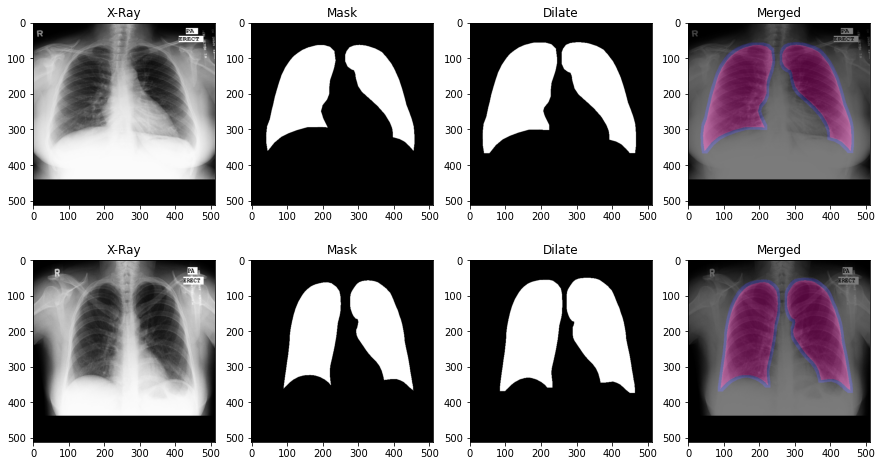

In [16]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(segmentation_image_dir,base_file)
mask_image_file = os.path.join(segmentation_mask_dir,base_file)

dilate_image_file = os.path.join(segmentation_dilate_dir,base_file)
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
fig, axs = plt.subplots( 2, 4, figsize=(15, 8))
axs[0,0].set_title("X-Ray")
axs[0,0].imshow(image)

axs[0,1].set_title("Mask")
axs[0,1].imshow(mask_image)
  
axs[0,2].set_title('Dilate')
axs[0,2].imshow(dilate_image)

axs[0,3].set_title("Merged")
axs[0,3].imshow(merged_image)


base_file = os.path.basename(montgomery_test[0])
filename,fileext  = os.path.splitext( base_file)
image_file = os.path.join(segmentation_test_dir,base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                                  "%s_mask%s" %(filename,fileext) )
dilate_image_file = os.path.join(segmentation_test_dir, \
                                    "%s_dilate%s" %(filename,fileext))
image = cv2.imread(image_file)

mask_image =cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)




In [17]:
shenzhen_mask_dir_1 = glob(os.path.join(shenzhen_mask_dir,'*.png'))
shenzhen_test = shenzhen_mask_dir_1[0:50]
shenzhen_train = shenzhen_mask_dir_1[50:]
for mask_file in tqdm(shenzhen_mask_dir_1):
  base_file = os.path.basename(mask_file).replace("_mask","")
  image_file = os.path.join(shenzhen_image_dir,base_file)
  
  image = cv2.imread(image_file)
  mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image,(512,512))
  mask = cv2.resize(mask,(512,512))

  mask_dilate = cv2.dilate(mask,DILATE_KERNEL,iterations=1)

  if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(segmentation_image_dir , base_file), \
                    image)
        cv2.imwrite(os.path.join(segmentation_mask_dir, base_file), \
                    mask)
        cv2.imwrite(os.path.join(segmentation_dilate_dir, base_file), \
                    mask_dilate)
      
  else:
    filename,fileext = os.path.splitext(base_file)
    cv2.imwrite(os.path.join(segmentation_test_dir, base_file), \
                    image)
    cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)
  


100%|██████████| 566/566 [33:43<00:00,  3.58s/it]


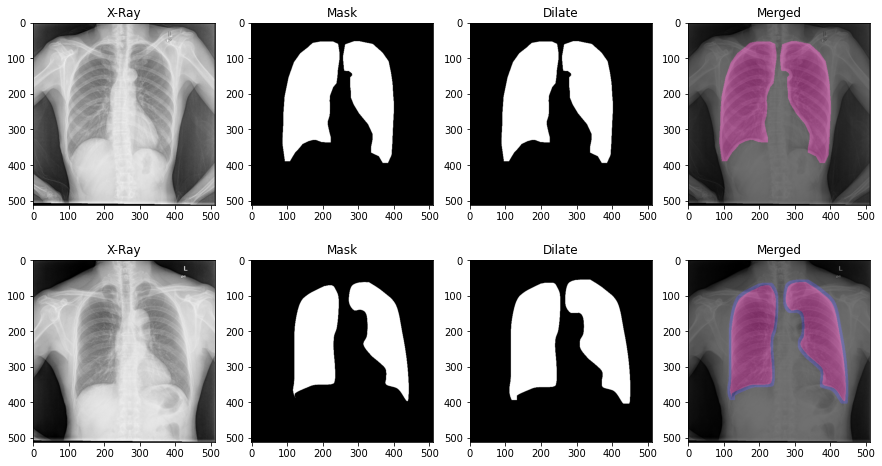

In [18]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask",""))
image_file = os.path.join(segmentation_image_dir,base_file)
mask_image_file = os.path.join(segmentation_dilate_dir,base_file)
dilate_image_file = os.path.join(segmentation_dilate_dir,base_file)
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image,mask_image,dilate_image)
fig,axs = plt.subplots(2,4,figsize=(15,8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask",""))
image_file = os.path.join(segmentation_test_dir,base_file)
filename,fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(segmentation_test_dir, base_file)
mask_image_file = os.path.join(segmentation_test_dir, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(segmentation_test_dir, \
                                 "%s_dilate%s" % (filename, fileext))
image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [19]:
train_files = glob(os.path.join(segmentation_image_dir, "*.png"))
test_files = glob(os.path.join(segmentation_test_dir, "*.png"))
mask_files = glob(os.path.join(segmentation_mask_dir, "*.png"))
dilate_files = glob(os.path.join(segmentation_dilate_dir, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(604, 300, 604, 604)

In [20]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [21]:
def mean_iou(y_true, y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)  
  
def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())



def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [22]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def segnet(input_size=(256,256,1)):
  inputs = Input(input_size)
    
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64,(3,3),activation='relu',padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

  conv2 = Conv2D(128,(3,3),activation='relu',padding='same')(pool1)
  conv2 = Conv2D(128,(3,3),activation='relu',padding ='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

  conv3 = Conv2D(256,(3,3),activation='relu',padding='same')(pool2)

  conv3 = Conv2D(256,(3,3),activation='relu',padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

  conv4 = Conv2D(512,(3,3),activation='relu',padding='same')(pool3)
  conv4 = Conv2D(512,(3,3),activation='relu',padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

  up7 = UpSampling2D(size=(2,2))(pool4)
  conv7 = Conv2D(512,(3,3),activation='relu',padding='same')(up7)
  conv7 = Conv2D(512,(3,3),activation='relu',padding='same')(conv7)

  up8 = UpSampling2D(size=(2,2))(conv7)
  conv8 = Conv2D(256,(3,3),activation='relu',padding='same')(up8)
  conv8 = Conv2D(256,(3,3),activation = 'relu',padding='same')(conv8)

  up9 = UpSampling2D(size=(2,2))(conv8)
  conv9 = Conv2D(128,(3,3),activation='relu',padding='same')(up9)
  conv9 = Conv2D(128,(3,3),activation='relu',padding='same')(conv9)

  up10 = UpSampling2D(size=(2,2))(conv9)
  conv10 = Conv2D(64,(3,3),activation='relu',padding='same')(up10)
  conv10 = Conv2D(64,(3,3),activation='relu',padding='same')(conv10)

  outheight = Model(inputs,conv10).output_shape[1]
  outputWidth = Model(inputs,conv10).output_shape[2]

  conv11 = Conv2D(1,(1,1),padding='same')(conv10)
 
  conv11 = Activation('sigmoid')(conv11)

   
  model=Model(inputs=[inputs], outputs=[conv11])
 
  return model





In [23]:
ACCURACY_THRESHOLD = 0.845

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_binary_accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [24]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [25]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(segmentation_test_dir, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

In [29]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            segmentation_train_dir,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(segmentation_aug_dir))

model = segnet(input_size=(512,512,1))
model.compile( optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy',mean_iou,precision,recall,sensitivity,specificity])
model.summary()

model_checkpoint = ModelCheckpoint('segnet_lung_seg1.hdf5', 
                                   monitor='loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_files) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[model_checkpoint,callbacks],
                    validation_data = validation_data)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 128)     0   

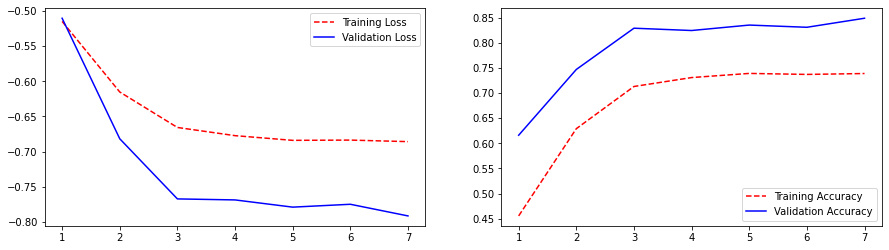

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

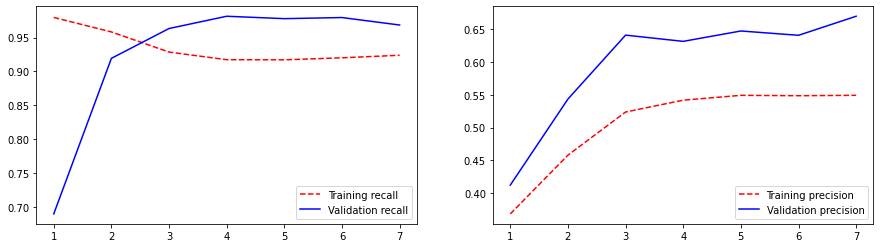

In [31]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = history.history['recall']
validation_recall = history.history['val_recall']

training_precision = history.history['precision']
validation_precision = history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])

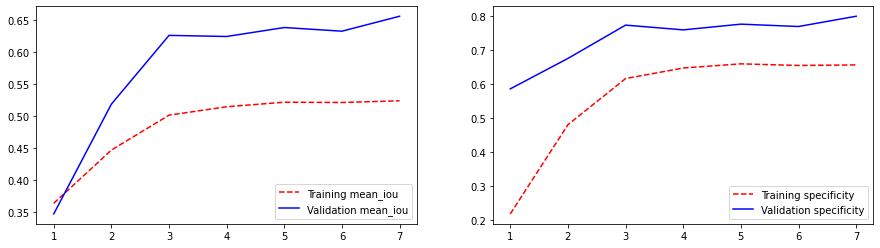

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou = history.history['mean_iou']
validation_mean_iou = history.history['val_mean_iou']

training_specificity = history.history['specificity']
validation_specificity = history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training mean_iou', 'Validation mean_iou'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])

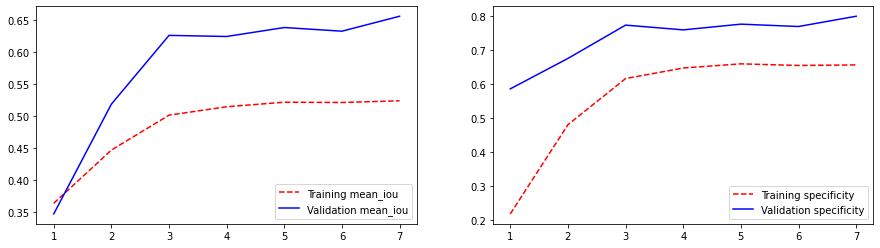

In [33]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou = history.history['mean_iou']
validation_mean_iou = history.history['val_mean_iou']

training_specificity = history.history['specificity']
validation_specificity = history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training mean_iou', 'Validation mean_iou'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])

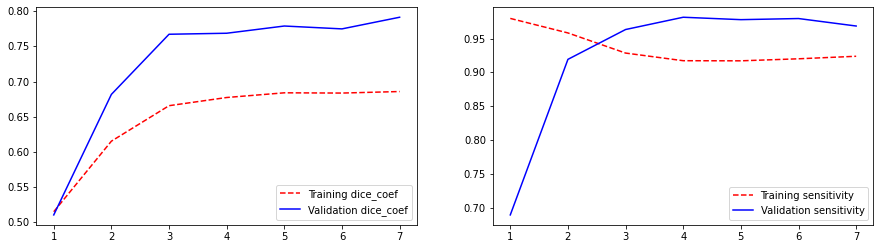

In [37]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_dice_coef = history.history['dice_coef']
validation_dice_coef = history.history['val_dice_coef']

training_sensitivity = history.history['sensitivity']
validation_sensitivity = history.history['val_sensitivity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_dice_coef, 'r--')
axs[0].plot(epoch_count, validation_dice_coef, 'b-')
axs[0].legend(['Training dice_coef', 'Validation dice_coef'])

axs[1].plot(epoch_count, training_sensitivity, 'r--')
axs[1].plot(epoch_count, validation_sensitivity, 'b-')
axs[1].legend(['Training sensitivity', 'Validation sensitivity'])

In [34]:
test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(segmentation_test_dir, results, test_files)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


100/100 [==============================] - 25s 247ms/step


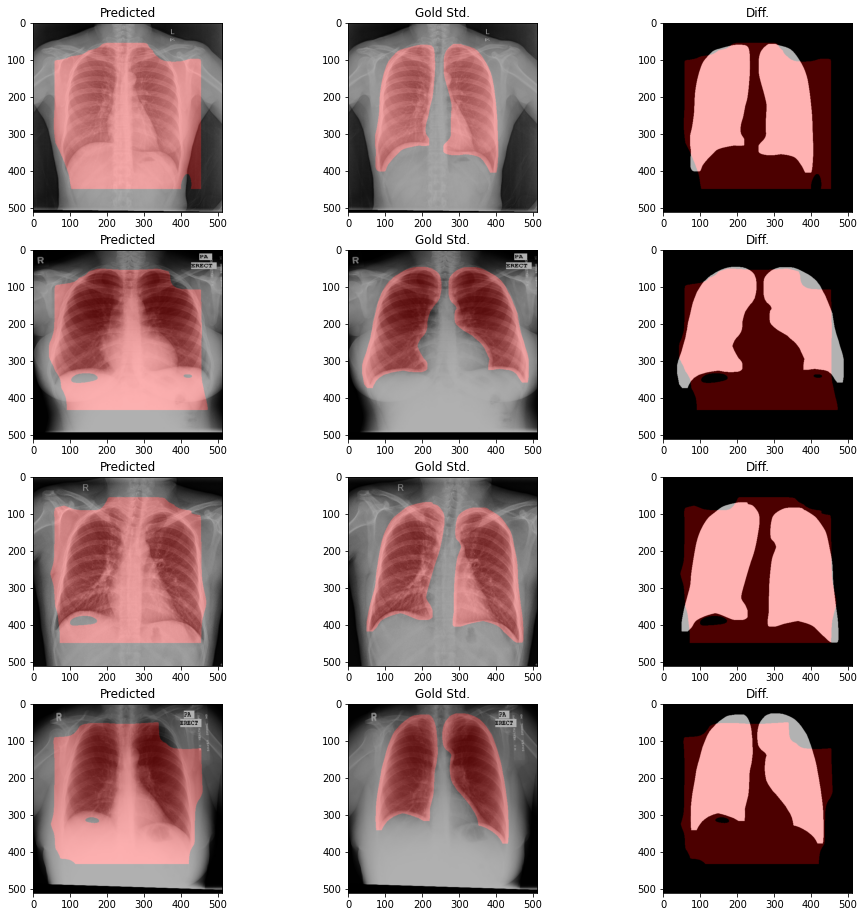

In [36]:
image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/CHNCXR_0003_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/CHNCXR_0003_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/CHNCXR_0003_0_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/MCUCXR_0003_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/MCUCXR_0003_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/MCUCXR_0003_0_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/CHNCXR_0020_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/CHNCXR_0020_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/CHNCXR_0020_0_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/MCUCXR_0016_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/MCUCXR_0016_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/research2/segmentation/test1/MCUCXR_0016_0_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))